In [1]:
# import os
# os.chdir('/Users/fionaspuler/Documents/GitHub/RMM-VAE/')

# import sys
# sys.path[0]='/Users/fionaspuler/Documents/GitHub/RMM-VAE/'

In [2]:
from keras.layers import Lambda, Input, Dense, Reshape, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mean_squared_error as mse
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, fowlkes_mallows_score 
from sklearn.metrics import completeness_score, silhouette_score, mean_squared_error, adjusted_rand_score

import pandas as pd
import numpy as np
import xarray as xr

from scipy import stats
import xesmf as xe
from math import ceil

import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

#from sklearn.metrics import silhouette_score

import clustering_functions as cf

In [3]:
execfile('pre_processing.py')

**import model specifications saved in yaml file**

In [4]:
import yaml
from yaml import CLoader as Loader
stream = open("model_specifications/RMM-VAE/v1/v5.yaml", 'r')
dictionary = yaml.load(stream, Loader=Loader)

filepath = dictionary['filepath']

original_dim = dictionary['original_dim']
inputdim1 = dictionary['inputdim1']
inputdim2 = dictionary['inputdim2']

latent_dim = dictionary['latent_dim']

activation_function = dictionary['activation_function']

dim_layer1 = dictionary['dim_layer1']
dim_layer2 = dictionary['dim_layer2']

cat_dim = dictionary['cat_dim']

batch_size = dictionary['batch_size']
epochs = dictionary['epochs']

cluster_number = dictionary['cluster_number']

reconstruction_loss_factor = dictionary['reconstruction_loss_factor']

In [5]:
input_shape = (original_dim, )
input_shape_r = (1, )

**Define sampling function**

In [6]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

**Input data**

In [7]:
X = cf.reshape_data_for_clustering(z500)
y = pr_boxcox_spatial

X_train_1, X_test_1, y_train, y_test = train_test_split(z500.values, y, test_size=0.33)

nt,ny,nx = X_train_1.shape
X_train = np.reshape(X_train_1, [nt, ny*nx], order='F')

nt,ny,nx = X_test_1.shape
X_test = np.reshape(X_test_1, [nt, ny*nx], order='F')

dummy_train = np.ones((X_train.shape[0],1))
dummy_test = np.ones((X_test.shape[0],1))
dummy_full = np.ones((X.shape[0],1))

### Define RMM-VAE Model

**Encoder**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 286)]                0         []                            
                                                                                                  
 encoder_intermediate (Dens  (None, 128)                  36736     ['encoder_input[0][0]']       
 e)                                                                                               
                                                                                                  
 encoder_intermediate_2 (De  (None, 64)                   8256      ['encoder_intermediate[0][0]']
 nse)                                                                                             
                                                                                            

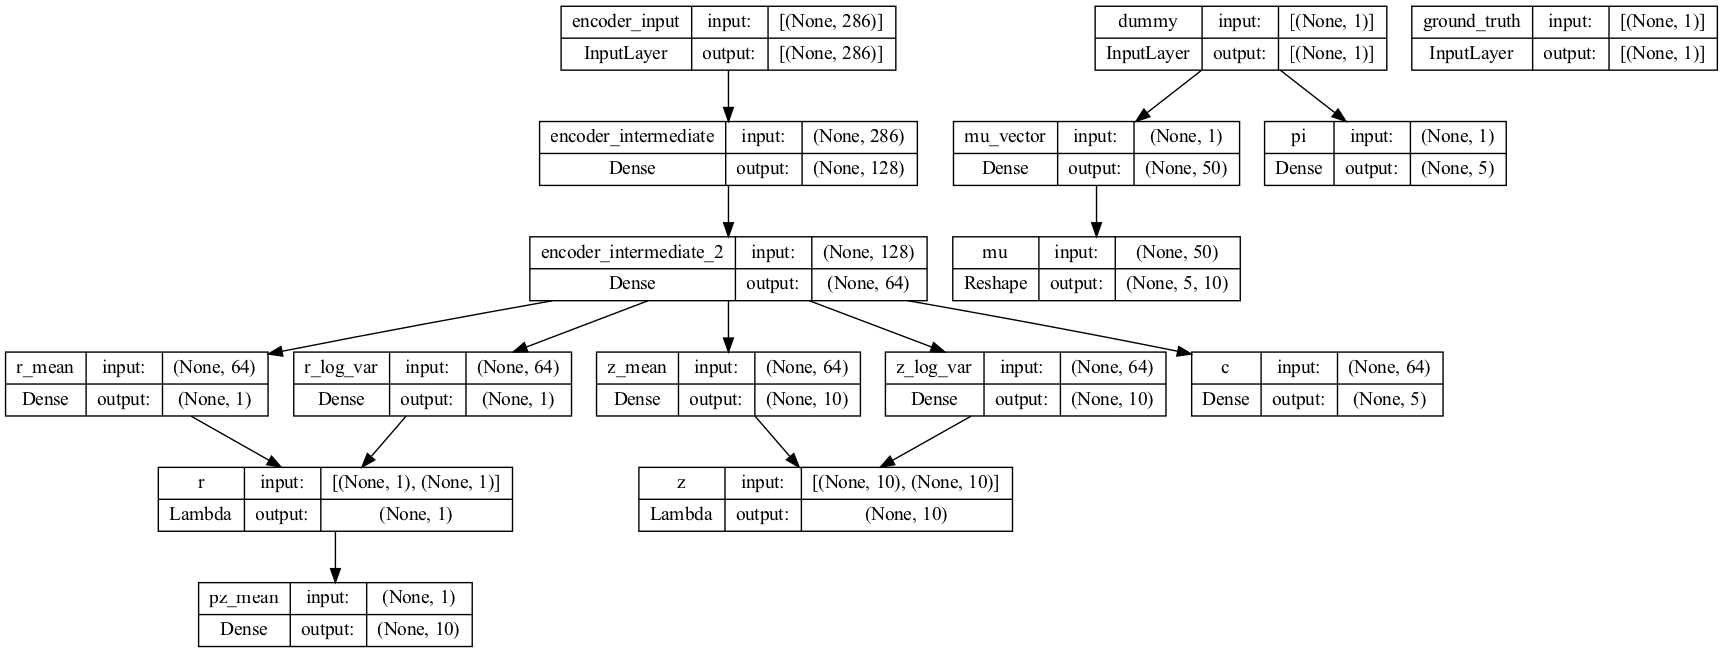

In [8]:
inputs = Input(shape=input_shape, name='encoder_input')
inputs_r = Input(shape=input_shape_r, name='ground_truth')

inter_x1 = Dense(dim_layer1, activation=activation_function, name='encoder_intermediate')(inputs)
inter_x2 = Dense(dim_layer2, activation=activation_function, name='encoder_intermediate_2')(inter_x1)

dummy = Input(shape=(1,), name='dummy')
mu_vector = Dense(cluster_number*latent_dim, name='mu_vector',use_bias=False)(dummy)
mu = Reshape((cluster_number,latent_dim), name='mu')(mu_vector)

pi = Dense(cluster_number, activation='softmax', name='pi')(dummy)
c = Dense(cluster_number, activation='softmax', name='c')(inter_x2)

z_mean = Dense(latent_dim, name='z_mean')(inter_x2)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x2)

r_mean = Dense(1, name='r_mean')(inter_x2)
r_log_var = Dense(1, name='r_log_var')(inter_x2)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(r)

encoder = Model([inputs,dummy, inputs_r], [z_mean, z_log_var, z, mu, c, pi, r_mean, r_log_var, r, pz_mean], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True, dpi=100)
plot_model(encoder, to_file=filepath+'encoder_graph.png', show_shapes=True, dpi=100)

**Decoder**

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 286)               36894     
                                                                 
Total params: 45918 (179.37 KB)
Trainable params: 45918 (179.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


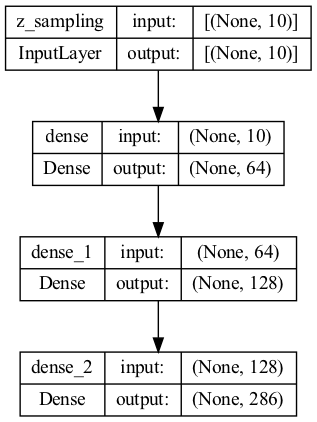

In [9]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(dim_layer2, activation=activation_function)(latent_inputs)
inter_y2 = Dense(dim_layer1, activation=activation_function)(inter_y1)
outputs = Dense(original_dim)(inter_y2)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True, dpi=100)
plot_model(decoder, to_file=filepath+'decoder_graph.png', show_shapes=True, dpi=100)

**combine encoder and decoder to VAE model and print summary**

In [10]:
outputs = decoder(encoder([inputs,dummy, inputs_r])[2])
vae = Model([inputs,dummy, inputs_r], outputs, name='vae_regression')
vae.summary()

Model: "vae_regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 286)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 10),                 46827     ['encoder_input[0][0]',       
                              (None, 10),                            'dummy[0][0]',  

**Define loss function**

In [11]:
reconstruction_loss = mse(inputs, outputs)*original_dim*reconstruction_loss_factor

# sum over reconstruction loss and kl-div loss
kl_loss_all = tf.compat.v1.get_variable("kl_loss_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)
kl_loss_all_2 = tf.compat.v1.get_variable("kl_loss_all_2", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)
kl_cat_all = tf.compat.v1.get_variable("kl_cat_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)
dir_prior_all = tf.compat.v1.get_variable("dir_prior_all", [batch_size,1], 
                                  dtype=tf.float32,initializer=tf.zeros_initializer)
label_loss_all = tf.compat.v1.get_variable("label_prior_all", [batch_size,1], 
                                  dtype=tf.float32,initializer=tf.zeros_initializer)

for i in range(0,cluster_number):
    
    kl_loss = 1 + z_log_var - K.square(z_mean-mu[:,i,:]) - K.exp(z_log_var)
    kl_loss = tf.multiply(K.sum(kl_loss, axis=-1), c[:,i])
    kl_loss = -0.5*(kl_loss)
    kl_loss_all = kl_loss_all + kl_loss
    
    kl_loss_2 = 1 + z_log_var - K.square(z_mean-pz_mean) - K.exp(z_log_var)
    kl_loss_2 = tf.multiply(K.sum(kl_loss_2, axis=-1), c[:,i])
    kl_loss_2 = -0.5*(kl_loss_2)
    kl_loss_all_2 = kl_loss_all_2 + kl_loss_2
    
    mc = K.mean(c[:,i])
    mpi = K.mean(pi[:,i])
    kl_cat = mc * K.log(mc)- mc * K.log(mpi)
    kl_cat_all = kl_cat_all+kl_cat
    
    dir_prior = -0.1*K.log(pi[:,i])
    dir_prior_all = dir_prior_all + dir_prior
    
    label_loss = tf.divide(0.5*K.square(r_mean - inputs_r), K.exp(r_log_var)) +  0.5 * r_log_var
    label_loss = tf.multiply(K.sum(label_loss, axis=-1), c[:,i])
    label_loss_all = label_loss_all + label_loss

In [12]:
vae_loss = K.mean(reconstruction_loss+kl_loss_all+kl_cat_all+label_loss_all+kl_loss_all_2+dir_prior_all)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.save_weights(filepath+'random_weights.h5')

Model: "vae_regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 286)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 10),                 46827     ['encoder_input[0][0]',       
                              (None, 10),                            'dummy[0][0]',  

**Evaluate convergence of loss function on test-train data split**

In [13]:
history = vae.fit([X_train,dummy_train, y_train], [X_train,dummy_train, y_train], epochs=epochs, 
                  batch_size=batch_size, 
                  validation_data=([X_test,dummy_test,y_test], [X_test,dummy_test,y_test]))

Epoch 1/100
66/66 [==============================] - 2s 7ms/step - loss: 170.3024 - val_loss: 107.5317
Epoch 2/100
66/66 [==============================] - 0s 3ms/step - loss: 81.7677 - val_loss: 67.3909
Epoch 3/100
66/66 [==============================] - 0s 3ms/step - loss: 64.2972 - val_loss: 60.1213
Epoch 4/100
66/66 [==============================] - 0s 3ms/step - loss: 56.4126 - val_loss: 53.3154
Epoch 5/100
66/66 [==============================] - 0s 4ms/step - loss: 52.0333 - val_loss: 50.7910
Epoch 6/100
66/66 [==============================] - 0s 4ms/step - loss: 49.6573 - val_loss: 48.7898
Epoch 7/100
66/66 [==============================] - 0s 4ms/step - loss: 47.8746 - val_loss: 47.1209
Epoch 8/100
66/66 [==============================] - 0s 4ms/step - loss: 46.7051 - val_loss: 46.1586
Epoch 9/100
66/66 [==============================] - 0s 4ms/step - loss: 45.9050 - val_loss: 45.1906
Epoch 10/100
66/66 [==============================] - 0s 4ms/step - loss: 45.0458 - val_l

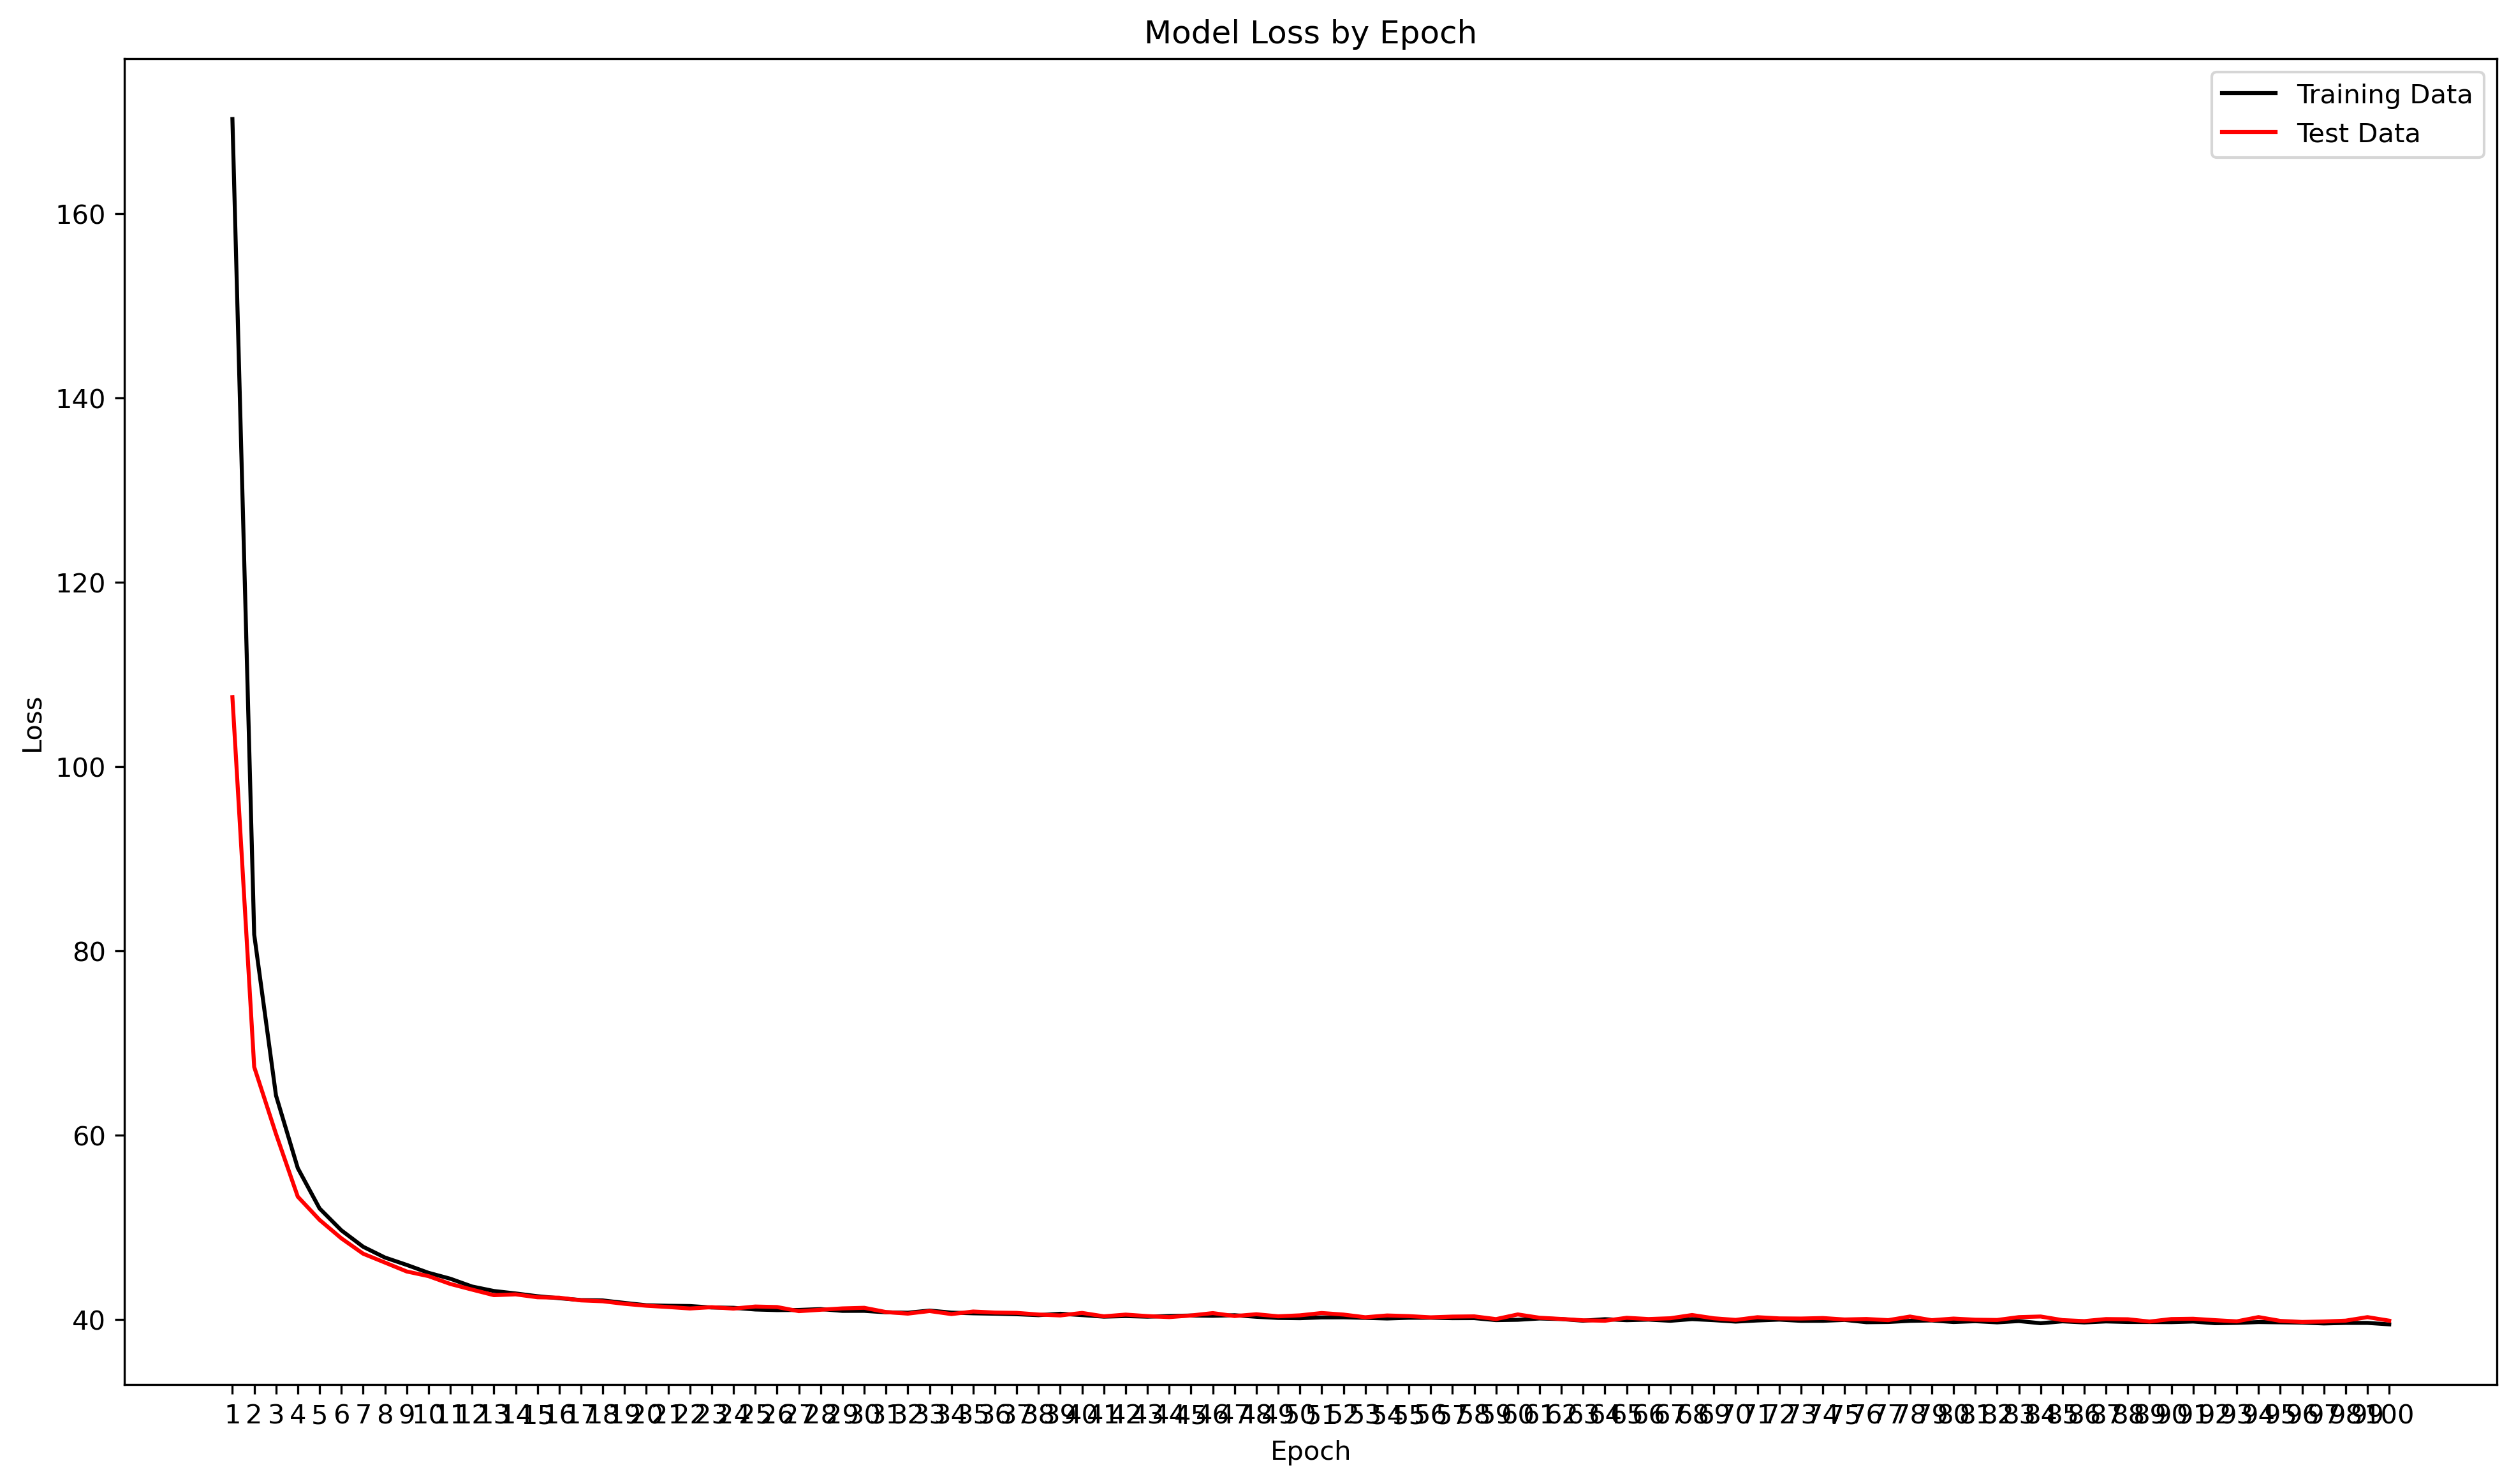

In [14]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()
fig.savefig(filepath+'loss_function.png')

**Load random weights and train on entire dataset**

In [15]:
vae.load_weights(filepath+'random_weights.h5')
vae.fit([X,dummy_full, y], epochs=epochs, 
                  batch_size=batch_size, 
                  verbose=1)
 
[z_mean, z_log_var, z, mu, c, pi, r_mean, r_log_var, r, pz_mean] = encoder.predict([X,dummy_full, y],batch_size=batch_size)


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 133.0724
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 66.3351
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 55.9577
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 51.3339
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 48.6744
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 46.9289
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 45.3295
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 44.5062
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 43.5960
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 43.1675
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 42.7293
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 42.4691
Epoch 13/100
99/99 [====

**Apply trained model**

In [16]:
X_decoded = decoder.predict(z)

393/393 [==============================] - 0s 308us/step


**Reconstruct flattened data to xarray lat-lon**

In [17]:
reconstructed = X_decoded.reshape(X_decoded.shape[0], inputdim2, inputdim1)
reconstructed = np.transpose(reconstructed, (0, 2, 1))
reconstructed_xr = xr.DataArray(reconstructed, coords=z500[0:X_decoded.shape[0], :, :].coords, 
                         dims=z500[0:X_decoded.shape[0], :, :].dims, attrs=z500[0:X_decoded.shape[0], :, :].attrs)

**save cluster probabilities and post likely labels, relabel data based on precipitation amount**

In [18]:
labels = np.zeros(X.shape[0])
for i in range(0, X.shape[0]):
    max_prob = np.max(c[i,:])
    idx = np.argmax(c[i,:])
    labels[i] = idx

df = pd.DataFrame(data=c)
df['label'] = labels
df.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'.csv')

In [19]:
pr_labeled = cf.assign_labels(xarray_array=pr, labels=labels)
pr_by_label = pr_labeled.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order = np.flip(np.argsort(pr_by_label.values)).tolist()

dict_replace = {0: cluster_order.index(0), 1: cluster_order.index(1), 2: cluster_order.index(2), 
                3: cluster_order.index(3), 4:cluster_order.index(4)}

def replace(element):
    return dict_replace.get(element, element)

vfunc = np.vectorize(replace)

relabeled_labels = vfunc(labels)

d = {'Labels': 'RMM-VAE', 'Value': relabeled_labels}
df = pd.DataFrame(data=d)
df.to_csv(filepath+'relabeled_labels.csv')

**t-sne visualisation**

In [20]:
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
X_2d = tsne.fit_transform(z)

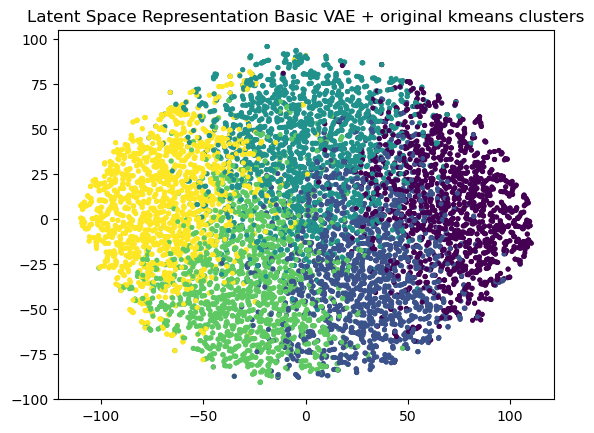

In [21]:
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=relabeled_labels, s=7)
plt.title('Latent Space Representation Basic VAE + original kmeans clusters')
#plt.legend(*scatter.legend_elements())
plt.savefig(filepath+'tsne_kmeans_'+str(cluster_number)+'.png')

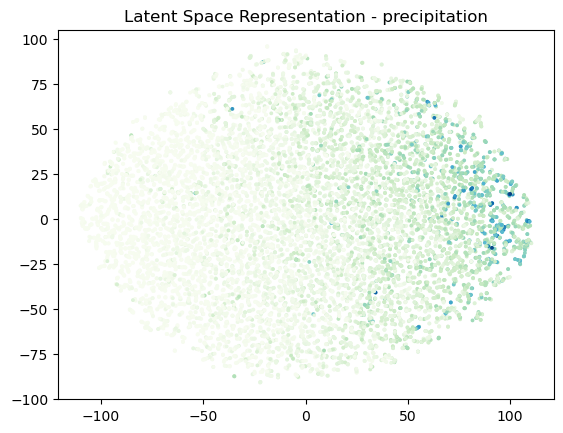

In [22]:
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pr_spatial.values, cmap='GnBu', s=3, alpha=1)
plt.title('Latent Space Representation - precipitation')
#plt.legend(*scatter.legend_elements(), loc='upper left')
plt.savefig(filepath+'tsne_precipitation_'+str(cluster_number)+'_nolegend.png')

**visualise cluster centers and precipitation odds ratios**

In [23]:
def visualise_contourplot_labels(cluster_centers, unit, regime_names, vmin, vmax, steps, color_scheme, 
                                   labels_data, labels, col_number=8, borders=True, projection = ccrs.Orthographic(0,45)):
    
    nt,ny,nx = cluster_centers.values.shape
    x,y = np.meshgrid(cluster_centers.longitude, cluster_centers.latitude)
    
    proj = projection
    fig, axes = plt.subplots(1,col_number, figsize=(14, 7), subplot_kw=dict(projection=proj))

    regimes = regime_names

    for i in range(nt):
        
        cluster=cluster_order[i]
        cs = axes.flat[i].contourf(x, y, cluster_centers[cluster, :, :],
                                   levels=np.arange(vmin, vmax, steps), 
                                   transform=ccrs.PlateCarree(),
                                   cmap=color_scheme)
        axes.flat[i].coastlines()
        
        if borders==True:
            axes.flat[i].add_feature(cartopy.feature.BORDERS)
            
        title = '{}, {:4.1f}%'.format(regimes[i], 100*labels_data[labels==cluster, :].shape[0]/labels_data.shape[0])
        axes.flat[i].set_title(title, fontsize=16)
    plt.tight_layout()
    
    return(fig)

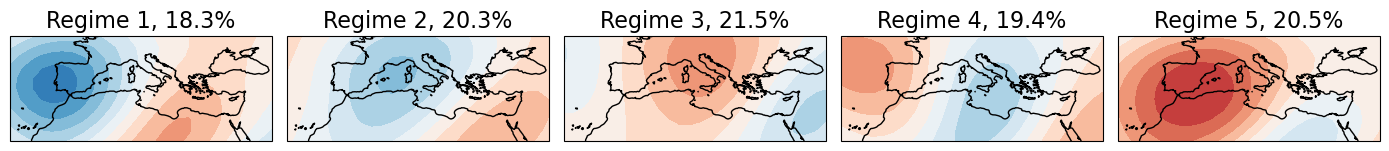

In [24]:
cluster_means_list = []

for i in range(cluster_number):
    reshaped = np.reshape(np.mean(X[labels == i,:],axis=0),[inputdim2,inputdim1])
    reshaped = np.transpose(reshaped, (1, 0))
    cluster_means_list.append(reshaped)
    
cluster_means = np.stack(cluster_means_list)

cluster_centers_xr = xr.DataArray(cluster_means, coords=z500[0:cluster_number, :, :].coords, 
                         dims=z500[0:cluster_number, :, :].dims, attrs=z500[0:cluster_number, :, :].attrs)

cluster_centers_vis = visualise_contourplot_labels(cluster_centers = cluster_centers_xr, unit = '[m]', 
                                            regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'], 
                                             vmin=-1.7, vmax=1.7, steps=0.2, 
                                             color_scheme = 'RdBu_r', 
                                                      labels_data = X, labels=labels,
                                                      borders=False, col_number=5, projection = ccrs.PlateCarree(central_longitude=0))

plt.savefig(filepath+'cluster_centers.png')

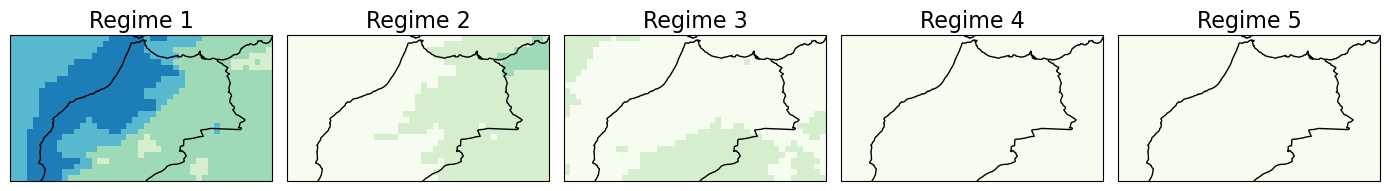

In [26]:
pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='',
                                             cluster_order=cluster_order,
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0), col_number=5)

plt.savefig(filepath+'oddsratio.png')

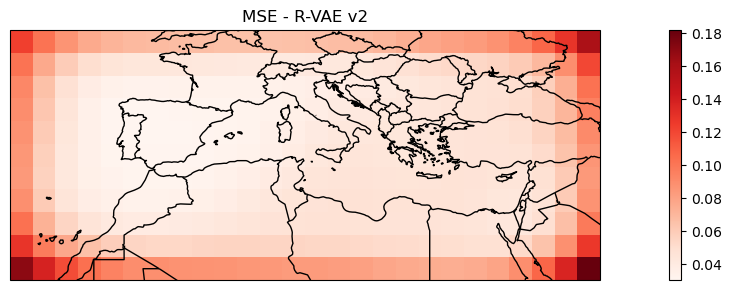

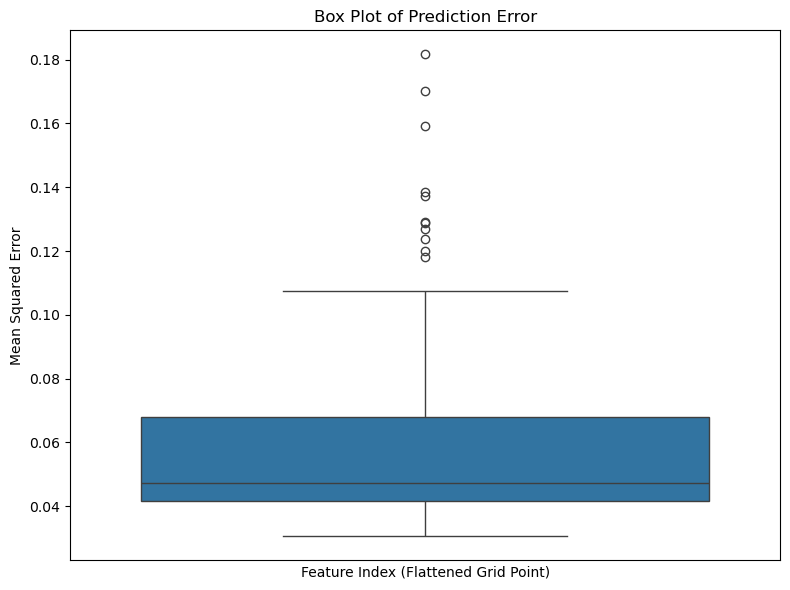

In [29]:
# calculate MSE
mse = mean_squared_error(X_decoded, z500_reshaped, multioutput='raw_values')
d = {'MSE': 'VAE_Regression', 'Value': mse}
df = pd.DataFrame(data=d)
df.to_csv(filepath+'mse.csv')

mse_reshaped = mse.reshape(ny,nx, order='F')
mse_reshaped_xr = xr.DataArray(mse_reshaped, coords=z500[0, :, :].coords, 
                     dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)

fig = plt.figure(figsize=[14,3])
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_reshaped_xr.plot(ax=ax1, cmap='Reds', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cartopy.feature.BORDERS)
ax1.set_title('MSE - R-VAE v2')
plt.tight_layout()
plt.savefig(filepath+'reconstructed_mse.png')

# Box plot of prediction error
plt.figure(figsize=(8, 6))
sns.boxplot(data=mse)
plt.title('Box Plot of Prediction Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Feature Index (Flattened Grid Point)')
plt.xticks([])
plt.tight_layout()
plt.savefig(filepath + 'predictive_mse_boxplot.png')
plt.show()